In [ ]:

!pip install pandas numpy scikit-learn imbalanced-learn tensorflow transformers shap lime gradio


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.2/57.2 MB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.4/320.4 kB 25.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.8/94.8 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 55.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.2/73.2 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 5.1 MB/s eta 0:00:00
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=f3aa3e13719fdfe3c696fd0936a1c926607495064500e5af728aaf163e080278
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 3.0.2
    Uninstalling MarkupSafe-3.0.2:
    

In [ ]:
import pandas as pd

# Load the uploaded CSV file to understand its structure
file_path = '/content/traincleaned_data (1).csv'
data = pd.read_csv(file_path)

# Display the first few rows of the dataset to understand its structure
data.head()


,BUN,SBP,BaseExcess,Phosphate,Creatinine,PaCO2,pH,Bilirubin_total,HCO3,HR,...,Magnesium,AST,Age,O2Sat,Temp,HospAdmTime,EtCO2,ICULOS,Alkalinephos,SepsisLabel
0,17.0,98.0,-0.689919,3.3,0.94,40.0,7.38,0.9,24.0,97.0,...,2.0,41.0,83.14,95.0,36.11,-0.03,33.0,1,74.0,0
1,17.0,98.0,-0.689919,3.3,0.94,40.0,7.38,0.9,24.0,97.0,...,2.0,41.0,83.14,95.0,36.11,-0.03,33.0,2,74.0,0
2,17.0,122.0,-0.689919,3.3,0.94,40.0,7.38,0.9,24.0,89.0,...,2.0,41.0,83.14,99.0,36.11,-0.03,33.0,3,74.0,0
3,17.0,133.0,-0.689919,3.3,0.94,40.0,7.38,0.9,24.0,104.0,...,2.0,41.0,83.14,95.0,36.11,-0.03,33.0,9,74.0,0
4,17.0,138.0,-0.689919,3.3,0.94,40.0,7.38,0.9,24.0,104.0,...,2.0,41.0,83.14,92.0,37.17,-0.03,33.0,12,74.0,0


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, precision_recall_curve, f1_score
from imblearn.over_sampling import SMOTE
import shap
from lime.lime_tabular import LimeTabularExplainer
import gradio as gr
import tensorflow as tf

from transformers import TFAutoModelForSequenceClassification  # Example for classification tasks

# 1. Load Dataset
data = pd.read_csv("/content/traincleaned_data (1).csv")  # Replace with actual dataset path
X = data.drop("SepsisLabel", axis=1)  # Features
y = data["SepsisLabel"]  # Target

# Handle missing values
X.fillna(X.mean(), inplace=True)

# 2. Address Class Imbalance with SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# 3. Split Data
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# 4. Train Random Forest (as part of the ensemble)
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict_proba(X_test)[:, 1]

# 5. Transformer-based Temporal Model
def create_transformer_model(input_dim):
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(input_dim,)),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

transformer_model = create_transformer_model(X_train.shape[1])
transformer_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

# 6. Combine Predictions
transformer_preds = transformer_model.predict(X_test).flatten()
ensemble_preds = (rf_preds + transformer_preds) / 2

# 7. Evaluate Model
roc_auc = roc_auc_score(y_test, ensemble_preds)
precision, recall, _ = precision_recall_curve(y_test, ensemble_preds)
f1 = f1_score(y_test, (ensemble_preds > 0.5).astype(int))

print(f"ROC-AUC: {roc_auc:.2f}, F1-Score: {f1:.2f}")




/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


Epoch 1/10
34283/34283 ━━━━━━━━━━━━━━━━━━━━ 71s 2ms/step - accuracy: 0.6043 - loss: 0.6969 - val_accuracy: 0.6626 - val_loss: 0.6110
Epoch 2/10
34283/34283 ━━━━━━━━━━━━━━━━━━━━ 82s 2ms/step - accuracy: 0.6598 - loss: 0.6126 - val_accuracy: 0.6748 - val_loss: 0.5985
Epoch 3/10
34283/34283 ━━━━━━━━━━━━━━━━━━━━ 71s 2ms/step - accuracy: 0.6730 - loss: 0.5996 - val_accuracy: 0.6806 - val_loss: 0.5933
Epoch 4/10
34283/34283 ━━━━━━━━━━━━━━━━━━━━ 81s 2ms/step - accuracy: 0.6792 - loss: 0.5944 - val_accuracy: 0.6836 - val_loss: 0.5902
Epoch 5/10
34283/34283 ━━━━━━━━━━━━━━━━━━━━ 70s 2ms/step - accuracy: 0.6815 - loss: 0.5913 - val_accuracy: 0.6893 - val_loss: 0.5865
Epoch 6/10
34283/34283 ━━━━━━━━━━━━━━━━━━━━ 80s 2ms/step - accuracy: 0.6837 - loss: 0.5891 - val_accuracy: 0.6894 - val_loss: 0.5846
Epoch 7/10
34283/34283 ━━━━━━━━━━━━━━━━━━━━ 70s 2ms/step - accuracy: 0.6847 - loss: 0.5881 - val_accuracy: 0.6854 - val_loss: 0.5846
Epoch 8/10
34283/34283 ━━━━━━━━━━━━━━━━━━━━ 80s 2ms/step - accuracy: 

In [ ]:
# Select a small representative sample of the test set for SHAP explanations
sampled_test_data = X_test[:100]  # Adjust size based on memory and performance


In [ ]:
explainer = shap.KernelExplainer(transformer_model.predict, sampled_test_data)
shap_values = explainer.shap_values(sampled_test_data)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


  0%|          | 0/100 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

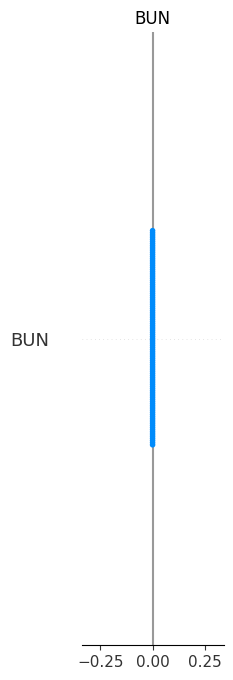

In [ ]:
# Generate a summary plot for SHAP values
shap.summary_plot(shap_values, sampled_test_data, feature_names=X.columns)


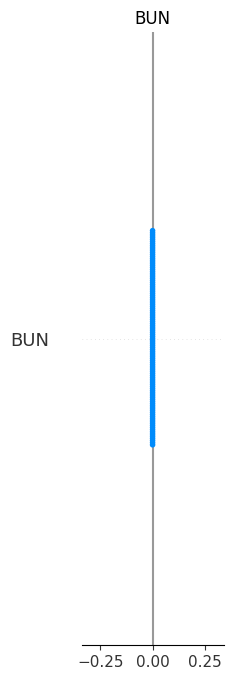

In [ ]:
# Bar plot for feature importance
shap.summary_plot(shap_values, sampled_test_data, feature_names=X.columns, plot_type="bar")


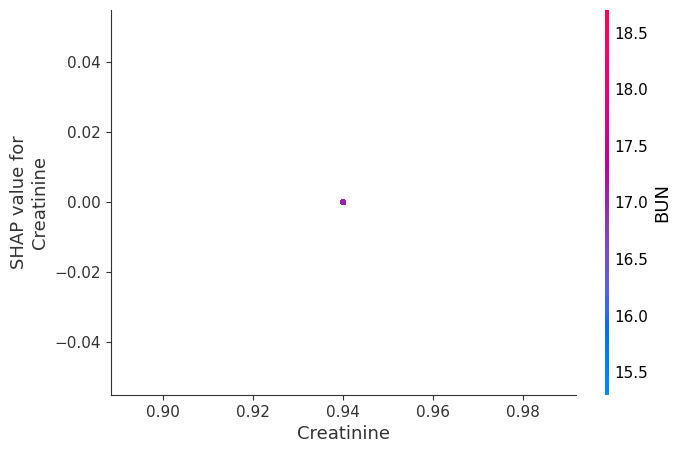

In [ ]:
# Dependence plot for a specific feature (e.g., "Age")
shap.dependence_plot("Creatinine", shap_values, sampled_test_data, feature_names=X.columns)


In [ ]:
# Force plot for a single prediction
shap.initjs()
# Reshape or select the appropriate dimension of shap_values
shap.force_plot(explainer.expected_value, shap_values[0,:,0], sampled_test_data.iloc[0], feature_names=X.columns)

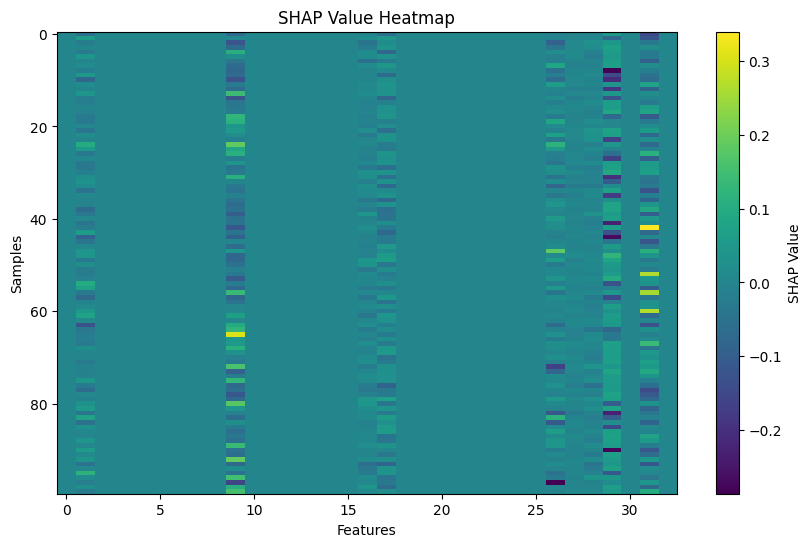

In [ ]:
# Heatmap for SHAP values
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
shap_values_array = np.array(shap_values)
plt.imshow(shap_values_array, aspect='auto', cmap='viridis')
plt.colorbar(label='SHAP Value')
plt.title('SHAP Value Heatmap')
plt.xlabel('Features')
plt.ylabel('Samples')
plt.show()


In [ ]:
import gradio as gr
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
# Gradio Prediction Function
def predict_with_shap(**inputs):
    # Convert inputs to array
    input_array = np.array(list(inputs.values())).reshape(1, -1)
    scaler = StandardScaler()
    # Scale and predict
    input_scaled = scaler.transform(input_array)
    prediction = transformer_model.predict(input_scaled).flatten()[0]

    # Compute SHAP values for the input
    shap_values_single = explainer.shap_values(input_scaled)

    # Generate force plot
    shap.force_plot(explainer.expected_value, shap_values_single[0], input_scaled[0], feature_names=X.columns, matplotlib=True) # Ensure matplotlib=True to get a matplotlib figure
    plt.close()  # Close the plot to prevent display issues

    # Return prediction and SHAP visualization as plot
    return {"Sepsis Risk Score": prediction}, plt


# Define Gradio Inputs
inputs = [gr.Number(label=col) for col in X.columns]

# Define Gradio Interface
interface = gr.Interface(
    fn=predict_with_shap,
    inputs=inputs,
    outputs=[
        gr.Textbox(label="Sepsis Risk Score"),
        gr.Plot(label="SHAP Explanation")  # Change to gr.Plot to display matplotlib plots
    ],
    live=True
)

# Launch Gradio App
interface.launch()

/usr/local/lib/python3.10/dist-packages/gradio/utils.py:1003: UserWarning: Expected 0 arguments for function <function predict_with_shap at 0x7c7876e79cf0>, received 33.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/gradio/utils.py:1011: UserWarning: Expected maximum 0 arguments for function <function predict_with_shap at 0x7c7876e79cf0>, received 33.
  warnings.warn(


Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://994bc20f88cbc6e4fa.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
# Ensure scaler is fitted outside the function with training data
scaler = StandardScaler()
scaler.fit(X_train)  # Fit scaler on the training data

# Default values based on the dataset structure
default_values = {
    "BUN": 17.0,                 # Blood Urea Nitrogen
    "SBP": 120.0,                # Systolic Blood Pressure
    "BaseExcess": 0.0,           # Base Excess
    "Phosphate": 3.5,            # Phosphate
    "Creatinine": 1.0,           # Creatinine
    "PaCO2": 40.0,               # Partial Pressure of CO2
    "pH": 7.4,                   # Blood pH
    "Bilirubin_total": 1.0,      # Total Bilirubin
    "HCO3": 24.0,                # Bicarbonate
    "HR": 80.0,                  # Heart Rate
    "Lactate": 1.2,              # Lactate
    "Chloride": 100.0,           # Chloride
    "Potassium": 4.0,            # Potassium
    "TroponinI": 0.01,           # Troponin I
    "Fibrinogen": 300.0,         # Fibrinogen
    "SaO2": 95.0,                # Oxygen Saturation
    "Resp": 18.0,                # Respiratory Rate
    "Gender": 1.0,               # Gender (e.g., 1 = Male, 0 = Female)
    "PTT": 30.0,                 # Partial Thromboplastin Time
    "Calcium": 9.0,              # Calcium
    "Bilirubin_direct": 0.5,     # Direct Bilirubin
    "Platelets": 250.0,          # Platelet Count
    "Glucose": 100.0,            # Glucose
    "WBC": 8.0,                  # White Blood Cell Count
    "Magnesium": 2.0,            # Magnesium
    "AST": 20.0,                 # Aspartate Aminotransferase
    "Age": 60.0,                 # Age
    "O2Sat": 95.0,               # Oxygen Saturation
    "Temp": 36.8,                # Temperature in Celsius
    "HospAdmTime": -1.0,         # Hours since hospital admission
    "EtCO2": 35.0,               # End-tidal CO2
    "ICULOS": 1.0,               # ICU Length of Stay
    "Alkalinephos": 70.0,        # Alkaline Phosphatase
}

def predict_with_shap(**inputs):
    # Convert inputs to array
    input_array = np.array(list(inputs.values())).reshape(1, -1)

    # Scale the input data using the pre-fitted scaler
    input_scaled = scaler.transform(input_array)

    # Predict with the model
    prediction = transformer_model.predict(input_scaled).flatten()[0]

    # Compute SHAP values for the input
    shap_values_single = explainer.shap_values(input_scaled)

    # Generate SHAP force plot
    shap_plot = shap.force_plot(
        explainer.expected_value,
        shap_values_single[0],
        input_scaled[0],
        feature_names=default_values.keys(),
        matplotlib=True  # To ensure a matplotlib figure is returned
    )

    # Close the plot to avoid display issues
    plt.close()
    prediction = transformer_model.predict(test_scaled).flatten()[0]

    # Return prediction and SHAP plot
    return {"Sepsis Risk Score": prediction}, shap_plot


# Define Gradio Inputs with default values
inputs = [
    gr.Number(label=col, value=default_values.get(col, 0)) for col in X.columns
]

# Define Gradio Interface
interface = gr.Interface(
    fn=predict_with_shap,
    inputs=[
        gr.Number(label=col, value=default_values.get(col, 0)) for col in default_values.keys()
    ],
    outputs=[
        gr.Textbox(label="Sepsis Risk Score"),
        gr.Plot(label="SHAP Explanation")
    ],
    live=True
)

# Launch the Gradio App
interface.launch()



/usr/local/lib/python3.10/dist-packages/gradio/utils.py:1003: UserWarning: Expected 0 arguments for function <function predict_with_shap at 0x7c7877026d40>, received 33.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/gradio/utils.py:1011: UserWarning: Expected maximum 0 arguments for function <function predict_with_shap at 0x7c7877026d40>, received 33.
  warnings.warn(


Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://cc0458f6f1ab183d83.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
# Test default values
test_input = np.array(list(default_values.values())).reshape(1, -1)
test_scaled = scaler.transform(test_input)

# Test model prediction
try:
    prediction = transformer_model.predict(test_scaled).flatten()[0]
    print("Test Prediction:", prediction)
except Exception as e:
    print("Model Prediction Error:", e)

# Test SHAP force plot
try:
    shap_values_single = explainer.shap_values(test_scaled)
    shap.force_plot(
        explainer.expected_value,
        shap_values_single[0],
        test_scaled[0],
        feature_names=list(default_values.keys()),
        matplotlib=True
    )
    plt.show()
except Exception as e:
    print("SHAP Plot Error:", e)


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
Test Prediction: 0.36073583


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
6607/6607 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step
SHAP Plot Error: matplotlib = True is not yet supported for force plots with multiple samples!


In [ ]:
def predict_with_shap(**inputs):
    try:
        # Step 1: Convert inputs to DataFrame with proper feature names
        input_df = pd.DataFrame([inputs], columns=list(default_values.keys()))
        print("Input DataFrame:", input_df)  # Debugging

        # Step 2: Scale the input data
        input_scaled = scaler.transform(input_df)
        print("Scaled Input:", input_scaled)  # Debugging

        # Step 3: Predict with the transformer model
        prediction = transformer_model.predict(input_scaled).flatten()[0]
        print("Prediction:", prediction)  # Debugging

        # Step 4: Compute SHAP values for the input
        shap_values_single = explainer.shap_values(input_scaled)
        print("SHAP Values Computed")  # Debugging

        # Step 5: Generate SHAP force plot
        # Static matplotlib force plot for a single sample
        shap_plot = shap.force_plot(
            explainer.expected_value,
            shap_values_single[0],
            input_scaled[0],
            feature_names=list(default_values.keys()),
            matplotlib=True
        )

        plt.close()  # Close the plot to prevent display issues

        # Return prediction and SHAP plot
        return {"Sepsis Risk Score": round(prediction, 4)}, shap_plot

    except Exception as e:
        print("Error in predict_with_shap function:", e)  # Log the error
        return {"Sepsis Risk Score": "Error"}, None
